# Plasmons in the Kretschmann-Raether Configuration

This project is a work in progress and is being completed as an assignment related to the Labratory Practices class in the Masters's Degree in Photonics (MDP) program at the University of Eastern Finland. The goal is to investigate surface plasmon propagation on metalic surface. In particular it is to first theoretically characterize the case of plasmons propagating on a gold film in the Kretschmann-Raether configuration across the visible range. After this has been completed the theoretical results will be compared with experiments results.

The fist task in this project was to use the materials provided to become more familiar with the concepts of surface plasmons (SPs), and specifically surface plasmon polaritons (SPPs). This included the publications by [Heinz Raether](http://www.fulviofrisone.com/attachments/article/406/raether_2.pdf) and the chapter regarding plasmons in the text by [Novotny and Hecht](https://www.photonics.ethz.ch/fileadmin/user_upload/Courses/NanoOptics/plasmonss.pdf). The second component of this project is to then develop a simulation of the provided system to:
<ul>
<li>The critical angle above which the surface plasmons can be excited. (Also explain why in the report)</li>
<li>The reflectivity spectra for two different linear polarizations (S and P, P divided by S) at different angles of incidence.</li>
<li>The dispersion relation of SPPs.</li>
<li>The influence of the metal thickness on the plasmon excitation should be examined.</li>    
<li>Examine the sensitivity of the plasmon to the surrounding by changing the refractive index of dielectric used.</li>
<li>Any other useful additions.</li>
</ul>

This simulation would be primarily based off equation 2.16 and 2.17 in the Raether text.
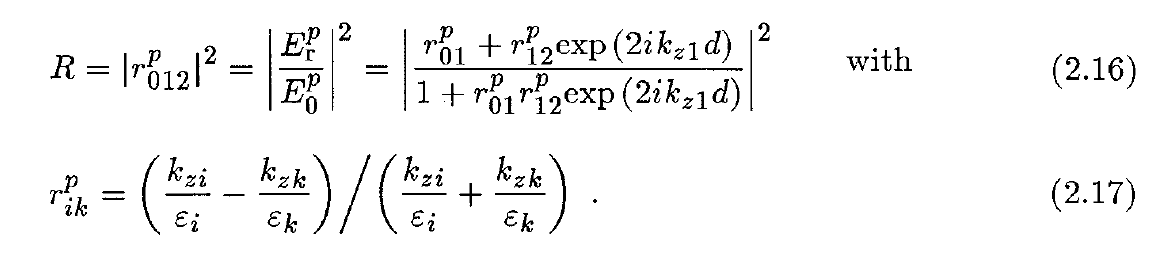

These equations show that the reflectivity will depend on the dieletric constants for the materials ($\epsilon_{ijk}$), the thickness of the film ($d$), and the wave vectors ($k_{zijk}$). Aditional equations from the text (2.3, 2.14) will be used to help find the values. Below is a sketch of the Kretschmann-Raether configuration.
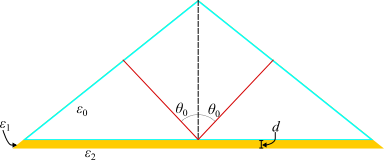

Heikki Rekola gave gave a description of the system as a prism of BK7 glass with a film of 50 nm thick gold (Au) on the base. The optical wavelengths will be approxiamted from 0.380-0.700 μm and angles 40-60$^\circ$ will be the range for finding important results. To start it is necessary to import the packages that will be used. I have handled imports a bit differently than I normaly would in an effort to increase readability.

In [ ]:
import pandas as pd
import numpy as np
from numpy import sin, pi as π #lib.scimath.sqrt as sqrt
from numpy.lib.scimath import sqrt
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

The next step is to define the varibles that are given (also the desired resolution of the simulation).

In [ ]:
#%% Givens
res = 101 #Number of points
λ_min = 0.380 #Approximate lower threshold for visible light
λ_max = 0.800 #Approximate lower threshold for visible light
λ = np.linspace(λ_min, λ_max, res) #Optical range in micrometers range from advisor
#λ = .550 #placeholder value for testing
θ_min = 40 #lower limit in degrees
θ_max = 60 #Upper limit in degrees 
θ = np.linspace(θ_min, θ_max, res) #Sugested range from advisor
#θ = 50 #placeholder value for testing
d = 0.05 #Film is given as 50 nm thick -->.05 micrometer
#ε0 = 8.8541878128E-18 #F/µm (farads per micrometer)
#c = 299792458 #Meters per second

Now to begin solving for the unknowns in the equations. The dieletric constants for the materials may be found from their refractive indices. While for some materials it is possible to consider the refractive index ($n$) as a constant, in reality it varries with wavelength ($\lambda$). For the sake of consistency, all three materials in the setup will be treated as similar as possible. First, the refractive index is retreived from https://refractiveindex.info/ an online database for refractive idices. This information is imported as a dataframe. These are then converted to numpy arrays, and then interpolated to be functions of wavelength.

In [3]:
n_Au = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/main/Au/Johnson.yml')
n_BK7 = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/glass/schott/N-BK7.yml')
n_Air = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/other/mixed%20gases/air/Ciddor.yml')

n_Au = (n_Au.apply(pd.to_numeric, errors='coerce')).to_numpy()[:49,:49]
n_BK7 = (n_BK7.apply(pd.to_numeric, errors='coerce')).to_numpy()[:101,:101]
n_Air = (n_Air.apply(pd.to_numeric, errors='coerce')).to_numpy()

n_Au = interpolate.interp1d(n_Au[:,0], n_Au[:,1])
n_BK7 = interpolate.interp1d(n_BK7[:,0], n_BK7[:,1])
n_Air = interpolate.interp1d(n_Air[:,0], n_Air[:,1])

If the refractive index is plotted across the optical spectrum, it becomes obvious why Au needed to be treated as a function rather than a constant.

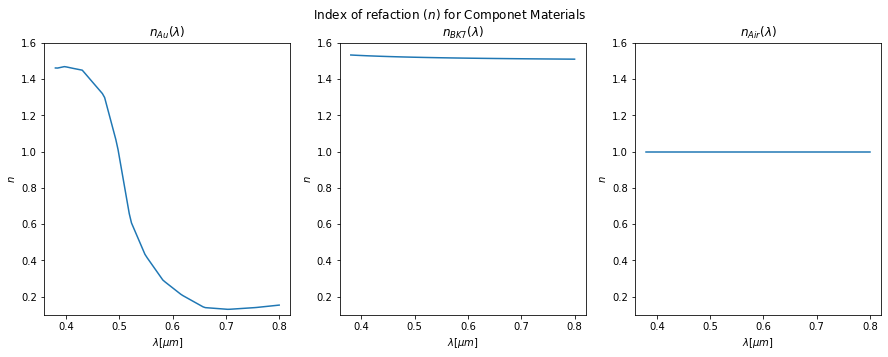

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [15, 5])
plt.suptitle('Index of refaction ($n$) for Componet Materials')
axs[0].set(title='$n_{Au} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[0].plot(λ,n_Au(λ))

axs[1].set(title='$n_{BK7} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[1].plot(λ,n_BK7(λ))

axs[2].set(title='$n_{Air} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[2].plot(λ,n_Air(λ))

The next step in being able to use equation 2.17 is to be able to solve for the dieletric properties for the materials in the system. For finding the relative permittivity, Hecht Optics gives the condition that when the material is non-magnetic Maxwell's Realtion may be applied, in which case the relative permittivity is simply the square of the refractive index.

In [12]:
#ε_0 = ε0*n_BK7(λ)**2
#ε_1 = ε0*n_Au(λ)**2
#ε_2 = ε0*n_Air(λ)**2
ε_0 = n_BK7(λ)**2
ε_1 = n_Au(λ)**2
ε_2 = n_Air(λ)**2

Equation 2.14 in Reather gives the formula for finding $k_x$ from the relative permittivity of the prism ($ε_0=n^2_\text{BK7}$) and $\sin(\theta_0)$ the angle of incidence with the prism. By inputting both $n(\lambda)$ and the range of $\theta_0$ to this equation, the result is $k_x(\lambda,\theta)$. Here the empty matrix is first preallocated, and then using nested for loops the values of $k_x$ are then filled in.

In [13]:
k_x = np.empty([res,res])
for n in range(res):
    for m in range(res):
        k_x[n, m] = (2*π*(n_BK7(λ[n])/λ[n])*sin(np.deg2rad(θ[m])))**2

Equation 2.3 gives the relation for $k_{zi}$ in terms of relative permeability, and $k_x$. So it is now possible to find $k_{zi}(\lambda, \theta)$

In [14]:
k_z0 = sqrt(ε_0*(2*π/λ)**2 - k_x)
k_z1 = sqrt(ε_1*(2*π/λ)**2 - k_x)
k_z2 = sqrt(ε_2*(2*π/λ)**2 - k_x)

Bringing this all together in equation 2.17 yields $r^p_{ik}(\lambda, \theta)$

In [15]:
rp_01 = (k_z0/ε_0 - k_z1/ε_1)/(k_z0/ε_0 + k_z1/ε_1)
rp_12 = (k_z1/ε_1 - k_z2/ε_2)/(k_z1/ε_1 + k_z2/ε_2)

With the help of equation 2.17, everything in equation 2.16 is now known, and $R_p(\lambda, \theta)$ may now be solved.

In [ ]:
Rp = np.abs(rp_01+rp_12*np.exp(2*1j*k_z1*d)/(1+rp_01*rp_12*np.exp(2*1j*k_z1*d)))**2 

Now it is possible to plot $R_p(\theta)$ for a range of wavelengths.

In [ ]:
plt.plot(θ, Rp[0,:], color = 'b')
plt.plot(θ, Rp[res-1,:], color = 'r')
plt.title('$R_p(\\theta)$')
plt.xlabel('$\\theta[^\circ]$')
plt.show()

Or $R_p(\lambda)$ across the range of $\theta_0$.

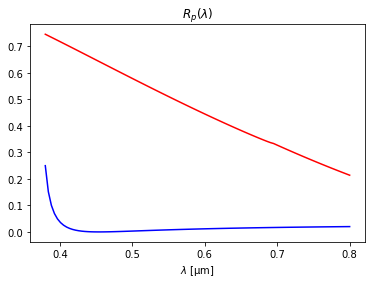

In [18]:
plt.plot(λ, Rp[:,0], color = 'b')
plt.plot(λ, Rp[:,res-1], color = 'r')
plt.title('$R_p(\lambda)$')
plt.xlabel('$\lambda$ [μm]')
plt.show()